Sam Lam
Thomas Verduyn

Project D: Computer exercise for WI4201
Solving the convection-diffusion equation using upwind finite
differences

In [1]:
# setup problem parameters/functions
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse
import sympy
import copy

def system_solver(N,e): # sets up system Au=f and solves it
    # Initial values
    h=1/N # nr of lines
    
    # Constant values - Boundary conditions
    u0=1
    unp1=0
    
    # Discretisation
    A=scipy.sparse.diags([-e/h-1, 2*e/h+1, -e/h], [-1, 0, 1], shape=(N-1, N-1)).toarray() 
    f=np.zeros(N-1)
    f[0]=e/h+1  # bring bc to rhs
    un=np.linalg.inv(A)@f
    return np.concatenate(([u0],un,[unp1])), A, f

def system_solver2(N,e):
    # Initial values
    h=1/N
    
    # Constant values - Boundary conditions
    u0=1
    unp1=0
    
    # Discretisation
    A=scipy.sparse.diags([-e/h-1, 2*e/h+1, -e/h], [-1, 0, 1], shape=(N-1, N-1)).toarray()
    A=np.vstack((np.zeros((1,N-1)),A,np.zeros((1,N-1))))
    A=np.hstack((np.zeros((N+1,1)),A,np.zeros((N+1,1))))
    A[0,0]=u0
    A[-1,-1]=unp1
    print(A)
    f=np.zeros(N+1)
    f[0]=e/h+1
    un=np.linalg.inv(A)@f
    return np.concatenate(([u0],un,[unp1])), A, f

def testfunc(N,e):
    x=np.linspace(0,1,N+1)
    return (np.exp(x/e)-np.exp(1/e))/(1-np.exp(1/e))

#system_solver2(3,0.5)

Problem 2

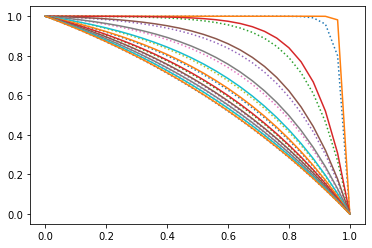

In [2]:
N=25
#%matplotlib notebook
eps = np.linspace(1e-2,1,11)
for e in eps:
    plt.plot(np.linspace(0,1,N+1),system_solver(N,e)[0],label=str(e),ls='dotted')
    plt.plot(np.linspace(0,1,N+1),testfunc(N,e),label='testfunc'+str(e))
#    plt.plot(np.linspace(0,1,N+2),(testfunc(N+2,e)-system_solver(N,e)[0])/testfunc(N+2,e),label=str(e))
#plt.legend()
plt.show()

Problem 2

[0.0625     0.03125    0.015625   0.0078125  0.00390625]


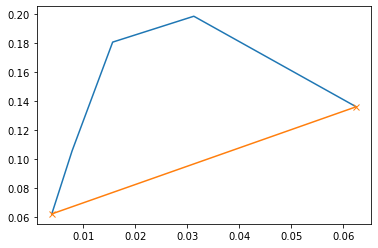

In [3]:
n=5
eps=0.01
error=[]
N_lst=[]
for i in range(4,n+4):
    N=2**i
    N_lst.append(N)
    un=system_solver(N,eps)
    error.append(max(np.abs(un[0]-testfunc(N,eps))))    
plt.plot(1/np.array(N_lst),error) # is not linear
plt.plot([1/N_lst[0],1/N_lst[-1]],[error[0],error[-1]],marker='x')
#plt.plot(range(5),error)
#plt.yscale('log')
print (1/np.array(N_lst))


Problem 3

To prove whether matrix A is symmetric or not we can use the transpose

In [4]:
A=system_solver(5,0.5)[1]
np.allclose(A,A.T)
print(sympy.Matrix(A).rref())
print(np.linalg.eig(A)[0])
print(np.linalg.inv(A))
np.any(np.linalg.inv(A)>=0)  # Check if A_ij>=0

(Matrix([
[1, 0, 0, 0],
[0, 1, 0, 0],
[0, 0, 1, 0],
[0, 0, 0, 1]]), (0, 1, 2, 3))
[10.78620908  7.82816919  1.21379092  4.17183081]
[[0.25961117 0.15933343 0.08770648 0.03654436]
 [0.2230668  0.38240023 0.21049554 0.08770648]
 [0.17190469 0.29469376 0.38240023 0.15933343]
 [0.10027774 0.17190469 0.2230668  0.25961117]]


True

Problem 4

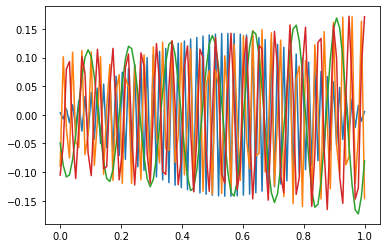

In [8]:
N=100
#%matplotlib notebook
eps=1
A=system_solver(N,eps)[1]
#print(A)
ev, ef=np.linalg.eig(A)
plt.plot(np.linspace(0,1,N-1),ef[:,::25])
#print(np.linspace(1/(N-1),1-1/(N-1),N-1))
plt.show()

#plt.plot(range(1,N),ev)
#plt.hist(ev,bins=len(ev))
#plt.show()

Problem 5

In [9]:
N=15
A=system_solver(N,0.5)[1]
D = np.diag(np.ones(N-1)*A[0,0])
B_jac=np.identity(N-1)-np.matmul(np.linalg.inv(D),A)
ev, ef=np.linalg.eig(B_jac)
#print(np.linalg.eig(A)[0])
print(max(np.abs(ev)))
#print(A)
#print(B_jac)
print(ev)


0.9762352868798306
[-0.97623529 -0.91175944 -0.80743534 -0.66782243 -0.49902248 -0.30841286
 -0.10432411  0.10432411  0.30841286  0.97623529  0.91175944  0.80743534
  0.66782243  0.49902248]


Problem 6

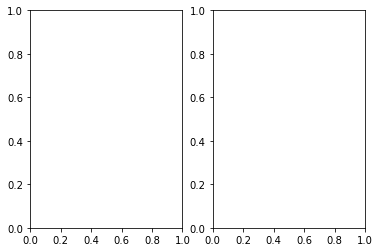

In [76]:
fig, ax = plt.subplots(1, 2)
N=8
eps=1.0

In [77]:
def jacobi(N,eps,rtol=1e-6):
    # Initial values
    h = 1 / N  # nr of lines

    # Constant values - Boundary conditions
    u0 = 1
    unp1 = 0

    # Discretization scheme and right-hand vector; CDS
    A = scipy.sparse.diags([-eps / h - 1, 2 * eps / h + 1, -eps / h], [-1, 0, 1], shape=(N - 1, N - 1)).toarray()
    f = np.zeros(N - 1)
    f[0] = eps / h + 1  # bring bc to rhs
    u_current=np.zeros(N-1)
    res_scaled=1
    u_new=np.zeros(N-1)
    res_lst = []
    while res_scaled>rtol:
        for i, row in enumerate(A):
            u_new[i]=(f[i]-(row@u_current-A[i,i]*u_current[i]))/A[i,i]
            #print(row,u_current)
        u_current=u_new
        res=f-A@u_new # res_k+1 = f - A*u_k
        res_scaled=np.sum(np.sqrt(res**2))/ np.sum(np.sqrt(f**2))
        res_lst.append(np.sum(np.sqrt(res**2)))
        
    return u_current, res_lst

u_jac, res_lst_jac =jacobi(N,eps)
# u0,A,f=system_solver(N,eps)

res_km1 = np.roll(res_lst_jac, shift=1)
red_jac = res_lst_jac / res_km1

ax[0].plot(res_lst_jac / np.max(f))
ax[1].plot(red_jac[2:], label="JAC")

Problem 7

In [78]:
def forwardGS(N, eps, rtol=1e-6):
    # Initial values
    h = 1 / N  # nr of lines

    # Constant values - Boundary conditions
    u0 = 1
    unp1 = 0

    # Discretization scheme and right-hand vector; CDS
    A = scipy.sparse.diags([-eps / h - 1, 2 * eps / h + 1, -eps / h], [-1, 0, 1], shape=(N - 1, N - 1)).toarray()
    f = np.zeros(N - 1)
    f[0] = eps / h + 1  # bring bc to rhs
    u_current = np.zeros(N-1)
    tol = 1
    u_new = np.zeros(N-1)
    res_scaled = 1  # initial residual
    res_lst = []
    while res_scaled>rtol:
        for i, row in enumerate(A):
            u_current[i] = (f[i]-row[:i]@u_current[:i]-row[i+1:]@u_current[i+1:])/A[i,i]
        res = np.sum(np.sqrt((f - A@u_current)**2))
        res_scaled = res / np.sum(np.sqrt(f**2))
        res_lst.append(res)
    return u_current, res_lst

u_gs, res_lst_gs = forwardGS(N,eps, rtol=1e-6)
#u_exact,A,f=system_solver(N,eps)
#print("Sol is close to exact sol: {}".format(np.allclose(u, u_exact[1:-1], rtol=1e-5)))
res_km1 = np.roll(res_lst_gs, shift=1)
red_gs = res_lst_gs / res_km1

# add curve to plot

ax[0].plot(res_lst_gs / np.max(f))
ax[1].plot(red_gs[1:], label="forward GS")

Problem 8

In [79]:
def backwardGS1(N, eps, rtol=1e-6):
    # Initial values
    h = 1 / N  # nr of lines

    # Constant values - Boundary conditions
    u0 = 1
    unp1 = 0

    # Discretization scheme and right-hand vector; CDS
    A = scipy.sparse.diags([-eps / h - 1, 2 * eps / h + 1, -eps / h], [-1, 0, 1], shape=(N - 1, N - 1)).toarray()
    f = np.zeros(N - 1)
    f[0] = eps / h + 1  # bring bc to rhs
    res = 1  # initial residual
    un = np.zeros(N - 1)  # solution vector; iterated
    res_scaled = 1  # initial residual
    res_lst = []
#     Solver
    while res > rtol:
        for i in range(N - 2, -1, -1):  # iterate backwards;
            s1=0
            for j in range(i+1,N-1): # sum of first part
                s1+=A[i,j]*un[j]
            s2=0
            for j in range(i,0,-1): # sum second part
                s2+=A[i,j-1]*un[j-1]
            un[i]=(f[i]-s1-s2)/A[i,i]
            res = np.sum(np.sqrt((f - A@un)**2))  # update residual;  using the infinity norm
            res_scaled = res / np.sum(np.sqrt(f**2))
            res_lst.append(res)
    return un, res_lst

u, res_lst_bgs = backwardGS1(N,eps)
#u_exact,A,f=system_solver(N,eps)
res_km1 = np.roll(res_lst_bgs, shift=1)
red_bgs = res_lst_bgs / res_km1

# add curve to plot

ax[0].plot(res_lst_bgs / np.max(f))
ax[1].plot(red_bgs[1:], label="backward GS")
#print("Sol is close to exact sol: {}".format(np.allclose(u, u_exact[1:-1])))

Sol is close to exact sol: True


Problem 9

In [80]:
def symmGS(N, eps, rtol=1e-6):
    # initial values
    h = 1 / N
    
    # Constant values - Boundary conditions
    u0 = 1
    unp1 = 0

    # Discretization scheme and right-hand vector; CDS
    A = scipy.sparse.diags([-eps / h - 1, 2 * eps / h + 1, -eps / h], [-1, 0, 1], shape=(N - 1, N - 1)).toarray()
    f = np.zeros(N - 1)
    f[0] = eps / h + 1  # bring bc to rhs
    res = 1  # initial residual
    un = np.zeros(N - 1)  # solution vector; iterated
    res_scaled = 1  # initial residual
    res_lst = []

    while res > rtol:
#        for i, row in enumerate(A):
#             u_current[i] = (f[i]-row[:i]@u_current[:i]-row[i+1:]@u_current[i+1:])/A[i,i]
#             res = f - A@u_current
#             tol=np.max(res)/np.max(f)
#        return u_current

        for i, row in enumerate(A):
            un[i] = (f[i]-row[:i]@un[:i]-row[i+1:]@un[i+1:])/A[i,i]
        while res > rtol:
            for i in range(N - 2, -1, -1):  # iterate backwards;
                s1=0
                for j in range(i+1,N-1): # sum of first part
                    s1+=A[i,j]*un[j]
                s2=0
                for j in range(i,0,-1): # sum second part
                    s2+=A[i,j-1]*un[j-1]
                un[i]=(f[i]-s1-s2)/A[i,i]
            res = np.sum(np.sqrt((f - A@un)**2))  # update residual;  using the infinity norm
            res_scaled = res / np.sum(np.sqrt(f**2))
            res_lst.append(res)
    return un, res_lst

u, res_lst_symmgs = symmGS(N, eps)
#u_exact,A,f=system_solver(N,eps)

#print("Sol is close to exact sol: {}".format(np.allclose(u, u_exact[1:-1])))     
res_km1 = np.roll(res_lst_symmgs, shift=1)
red_symmgs = res_lst_symmgs / res_km1

# add curve to plot

ax[0].plot(res_lst_symmgs / np.max(f))
ax[1].plot(red_symmgs[1:], label="backward GS")

In [82]:
# solve settings 
ax[0].set_yscale("log")
#ax[1].set_yscale("log")
ax[0].grid()
ax[1].grid()
#ax[1].set_xlim(0, 5)
#ax[0].set_xlim(0, 5)
ax[1].legend()
#ax[1].set_yscale("log")
fig.show()

c:\users\sam\anaconda3\envs\potentialsolver\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  # Remove the CWD from sys.path while we load stuff.
